# Imports

In [1]:
import sys
sys.path.insert(0, "../")

from random import sample

import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from triage.triage import Triage

#### Import data and train a regressor

In [2]:
np.random.seed(0)

dataset = fetch_openml(name="house_sales", version=3)

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

# standardize y
y = np.array([(y[i] - y.min()) / (y.max() - y.min()) for i in range(len(y))])

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(
    X_train, y_train, test_size=0.25
)

# fit regressor
nest = 20
learner = xgb.XGBRegressor(n_estimators=nest)
learner.fit(X_prop_train, y_prop_train)

/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Compute TRIAGE scores

In [3]:
X_eval = X_prop_train
y_eval = y_prop_train

# Instantiate TRIAGE
triage = Triage(
    X_eval=X_eval, y_eval=y_eval, X_cal=X_cal, y_cal=y_cal, nest=nest, learner=learner
)

# run Triage
groups_ids, raw_metrics = triage.run()

#### Get metrics & plot TRIAGE dynamics

In [4]:
score_metric = raw_metrics["score_metric"]

ue_ids = groups_ids["ue_group"] # under-estimated ids
oe_ids = groups_ids["oe_group"] # over-estimated ids
we_ids = groups_ids["we_group"] # well-estimated ids

In [5]:
# CUSTOM - can be changed based on application

percentile_thresh = 75
conf_thresh = 0.33

conf_thresh_low = conf_thresh
conf_thresh_high = 1 - conf_thresh

uncertainty = np.std(score_metric, axis=-1) 
confidence = np.mean(score_metric, axis=-1)

# over-estimated
oe_group = np.where(
(confidence <= conf_thresh_low)
& (uncertainty <= np.percentile(uncertainty, percentile_thresh))
)[0]

# under-estimated
ue_group = np.where(
(confidence >= conf_thresh_high)
& (uncertainty <= np.percentile(uncertainty, percentile_thresh))
)[0]

ue_oe_group = np.concatenate((ue_group, oe_group))

# well estimated
we_group = []
for id in range(len(confidence)):
    if id not in ue_oe_group:
        we_group.append(id)


we_group = np.array(we_group)

### Visualize the TRIAGE score's learning dynamics

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


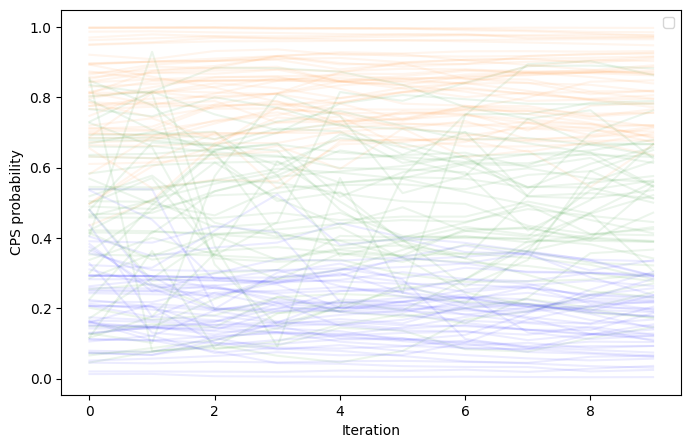

In [6]:
plt.figure(figsize=(8, 5))

alpha_val = 0.075
n = 50
e = 10
sample_ids = sample(range(len(ue_ids)), n)
for i in sample_ids:
    plt.plot(
        range(score_metric[0, :e].shape[0]),
        score_metric[ue_ids[i], :e],
        color="tab:orange",
        alpha=alpha_val,
    )

sample_ids = sample(range(len(we_ids)), n)
for i in sample_ids:
    plt.plot(
        range(score_metric[0, :e].shape[0]),
        score_metric[we_ids[i], :e],
        color="g",
        alpha=alpha_val,
    )

sample_ids = sample(range(len(oe_ids)), n)
for i in sample_ids:
    plt.plot(
        range(score_metric[0, :e].shape[0]),
        score_metric[oe_ids[i], :e],
        color="b",
        alpha=alpha_val,
    )


plt.ylabel("CPS probability")
plt.xlabel("Iteration")
plt.legend(loc=1)